In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import random
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import pickle


In [2]:
# Dataset paths
ravdess_path = r"C:\Users\abdul\Downloads\audio-testing\RAVDESS-AUDIO-DATASET"
crema_path = r"C:\Users\abdul\Downloads\audio-testing\CREMA-D -AUDIO-DATASET"
tess_path = r"C:\Users\abdul\Downloads\audio-testing\TESS Toronto emotional speech set data"

# Label extractors
def extract_label_ravdess(file):
    parts = os.path.basename(file).split("-")
    return {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }.get(parts[2], "unknown")

def extract_label_crema(file):
    return {
        'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fearful',
        'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
    }.get(os.path.basename(file).split('_')[2], "unknown")

def extract_label_tess(file):
    return os.path.basename(file).split('_')[-1].replace('.wav', '').lower()


In [3]:
def add_noise(y, noise_factor=0.005):
    return y + noise_factor * np.random.randn(len(y))

def shift_audio(y, shift_max=0.2):
    shift = int(random.uniform(-shift_max, shift_max) * len(y))
    return np.roll(y, shift)

def stretch_audio(y, rate=1.1):
    try:
        return librosa.effects.time_stretch(y, rate)
    except:
        return y

def pitch_shift_audio(y, sr, n_steps=2):
    try:
        return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    except:
        return y


In [4]:
def extract_features(file, label_extractor, augment=False):
    try:
        y, sr = librosa.load(file, sr=22050, mono=True)

        if augment:
            aug = random.choice(['noise', 'shift', 'stretch', 'pitch'])
            if aug == 'noise': y = add_noise(y)
            elif aug == 'shift': y = shift_audio(y)
            elif aug == 'stretch': y = stretch_audio(y, random.uniform(0.8, 1.2))
            elif aug == 'pitch': y = pitch_shift_audio(y, sr, random.randint(-2, 2))

        features = []

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features.extend(np.mean(mfccs, axis=1))
        features.extend(np.std(mfccs, axis=1))

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features.extend(np.mean(chroma, axis=1))
        features.extend(np.std(chroma, axis=1))

        zcr = librosa.feature.zero_crossing_rate(y)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        rms = librosa.feature.rms(y=y)
        features.append(np.mean(rms))
        features.append(np.std(rms))

        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features.extend(np.mean(contrast, axis=1))
        features.extend(np.std(contrast, axis=1))

        label = label_extractor(file)
        return features, label

    except Exception as e:
        print(f"Error with {file}: {e}")
        return None, None


In [5]:
data = []

# RAVDESS
for file in glob(os.path.join(ravdess_path, '**', '*.wav'), recursive=True):
    f, l = extract_features(file, extract_label_ravdess)
    if f and l != "unknown":
        data.append((f, l))

# CREMA-D
for file in glob(os.path.join(crema_path, '*.wav')):
    f, l = extract_features(file, extract_label_crema)
    if f and l != "unknown":
        data.append((f, l))

# TESS
for file in glob(os.path.join(tess_path, '**', '*.wav')):
    f, l = extract_features(file, extract_label_tess)
    if f and l != "unknown":
        data.append((f, l))


In [6]:
features, labels = zip(*data)
df = pd.DataFrame(features)
df['labels'] = labels

# Encode labels
le = LabelEncoder()
df['labels'] = le.fit_transform(df['labels'])

X = df.drop(columns='labels').values
y = df['labels'].values

# Normalize
pt = PowerTransformer()
X = pt.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# One-hot encode target
y = to_categorical(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [7]:
model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=32, callbacks=[es])


c:\Users\abdul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.4090 - loss: 1.9745 - val_accuracy: 0.7390 - val_loss: 0.9141
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7316 - loss: 0.8247 - val_accuracy: 0.7723 - val_loss: 0.5974
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7958 - loss: 0.5715 - val_accuracy: 0.8099 - val_loss: 0.5167
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8225 - loss: 0.4779 - val_accuracy: 0.8217 - val_loss: 0.4886
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8458 - loss: 0.4439 - val_accuracy: 0.8389 - val_loss: 0.4490
Epoch 6/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8491 - loss: 0.4004 - val_accuracy: 0.8475 - val_loss: 0.4279
Epoch 7/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8585 - loss: 0.3917 - val_accuracy: 0.8453 - val_loss: 0.4071
Epoch 8/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8817 - loss: 0.3408 - val_accuracy: 0.8647 - val_lo

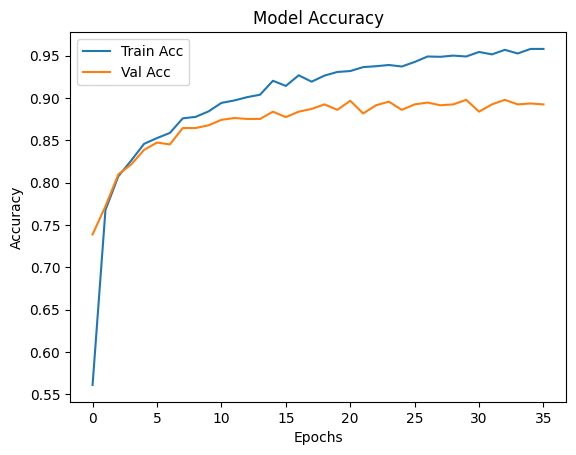

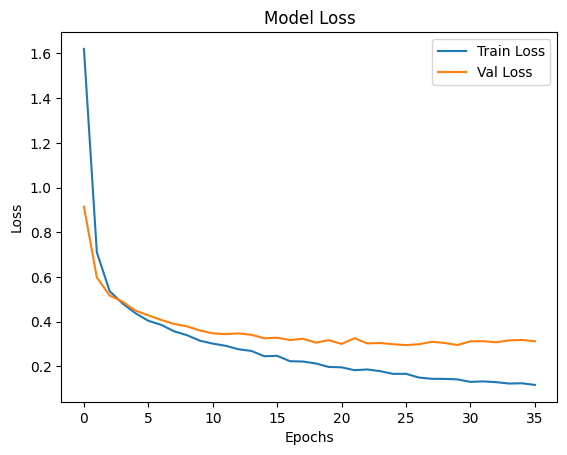

In [8]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [9]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8981 - loss: 0.2816
Test Accuracy: 89.26%


In [10]:
# Save the model
model.save("lstm_emotion_model.h5")

# Save preprocessors
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("pt.pkl", "wb") as f:
    pickle.dump(pt, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [11]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# Load saved model and preprocessors
model = load_model("lstm_emotion_model.h5")

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("pt.pkl", "rb") as f:
    pt = pickle.load(f)

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Define a dummy label extractor for testing (no label needed, just return 'neutral' or anything valid)
def dummy_label_extractor(file):
    return 'neutral'

# Import your feature extractor
# from your_project import extract_features  # if not in this script

# Path to your external .wav file
file_path = r"C:\Users\abdul\Downloads\audio-testing\anger.wav"

# Extract features (use dummy label extractor)
features, _ = extract_features(file_path, dummy_label_extractor)

# Predict
if features:
    X_new = np.array(features).reshape(1, -1)
    X_new = pt.transform(X_new)
    X_new = scaler.transform(X_new)
    X_new = X_new.reshape((1, 1, X_new.shape[1]))  # (batch, timesteps, features)

    prediction = model.predict(X_new)
    predicted_emotion = le.inverse_transform([np.argmax(prediction)])

    print("🎧 Predicted Emotion:", predicted_emotion[0])
else:
    print("❌ Failed to extract features from the audio file.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
🎧 Predicted Emotion: happy
